<div align="center"> МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ ЛЬВІВСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ ІМЕНІ ІВАНА ФРАНКА
                                
Факультет електроніки та комп’ютерних технологій
</div>


# Практична робота №3.  Класифікація твітів за тональністю з використанням Word2Vec та scikit-learn моделей
**Предмет:** Машинне навчання  
**Рівень:** 4 рік навчання  
**Датасет:** : COVID-19 NLP Text Classification Dataset 

**Завдання:** побудувати класифікаційні моделі для прогнозування тональності (Sentiment) твітів.
**Особливість:** на вхід моделі подаються векторні представлення текстів (embeddings), отримані з допомогою Word2Vec (gensim Link ). Додатково потрібно дослідити, як зниження розмірності ознак за допомогою PCA впливає на точність класифікації.

**Виконав:** студент групи ФЕІ-44 Низькошапка О. С.

**Перевірив** доцент Сінькевич О. О.


## 2. Вміст роботи

У цій роботі реалізовано повний цикл обробки твітів COVID-19 для класиф

1. **Підготовка даних**
- Завантаження CSV файлів (train/test або один файл із поділом 80/20).
- Виявлення текстової колонки та колонки лейблів.
- Попередня обробка тексту: приведення до нижнього регістру, очищення від посилань, тегів та небажаних символів.
- Токенізація та видалення стоп-слів.
- Фільтрація рядків без токенів.
- Мапінг оригінальних лейблів до трьох класів: Positive, Negative, Other.


2. **Навчання Word2Vec**
- Створення векторних представлень слів на базі токенізованих твітів (розмірність векторів 100).
- Агрегація токенів у вектори твітів (середнє арифметичне).


3. **Побудова моделей і пайплайнів**
- Використання scikit-learn Pipeline для поєднання PCA (опційно) та класифікаторів.
- Чотири моделі: Logistic Regression, Linear SVM, Random Forest, Gaussian Naive Bayes.
- Експерименти з PCA: None (без зниження розмірності), 50, 100, 200 компонент.


4. **Оцінка моделей**
- Метрики: Accuracy, Precision, Recall, F1-score для кожного класу.
- Побудова та відображення матриць плутанини для всіх моделей, LogisticRegression виводиться на екран.
- Збереження результатів у таблицю `results_table.csv`.


5. **Візуалізація та аналіз**
- Вивід таблиці з усіма метриками для всіх моделей і варіантів PCA.
- Графіки впливу кількості компонент PCA на точність для кожної моделі.


6. **Прогноз для нового тексту**
- Функція `predict_new_text` дозволяє подати новий твіт і отримати прогноз класу з використанням тренованого pipeline.



In [6]:
import os
import re
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import class_weight
sns.set(style="whitegrid")


## Налаштування параметрів

Задаємо шляхи до файлів, розмірність Word2Vec векторів, параметри PCA та розмір тестової вибірки.


In [7]:
TRAIN_PATH = "Corona_NLP_train.csv"
TEST_PATH = "Corona_NLP_test.csv"
SINGLE_PATH = "Crona_NLP.csv"
TEXT_COL_CANDIDATES = ["OriginalTweet", "Original Tweet", "OriginalTweet_text", "text", "tweet", "tweet_text"]
LABEL_COL_CANDIDATES = ["Sentiment", "Label", "label", "sentiment"]

RANDOM_STATE = 42
TEST_SIZE = 0.2
W2V_SIZE = 100
W2V_WINDOW = 5
W2V_MIN_COUNT = 2
W2V_EPOCHS = 10
PCA_COMPONENTS_LIST = [None, 50, 100, 200]

nltk.download("punkt")
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Функції для підготовки тексту

Тут реалізовані функції:
- clean_text: очищення тексту
- tokenize: токенізація та видалення стоп-слів
- tweet_vector: середнє значення векторів слів
- find_column: пошук колонки за можливими іменами
- standardize_columns: нормалізація назв колонок на "text" та "label"


In [8]:
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#", " ", s)
    s = re.sub(r"[^a-zA-Z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize(text: str):
    toks = word_tokenize(str(text))
    toks = [t for t in toks if t.isalpha() and t not in STOPWORDS and len(t) > 1]
    return toks

def tweet_vector(tokens, model, vector_size):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size, dtype=float)
    return np.mean(vecs, axis=0)

def find_column(df_cols, candidates):
    for c in candidates:
        if c in df_cols:
            return c
    return None

def standardize_columns(df):
    cols = df.columns
    txt_col = find_column(cols, TEXT_COL_CANDIDATES)
    lbl_col = find_column(cols, LABEL_COL_CANDIDATES)
    if txt_col is None or lbl_col is None:
        txt_guess, lbl_guess = None, None
        for c in cols:
            cl = c.lower()
            if txt_guess is None and ("tweet" in cl or "text" in cl):
                txt_guess = c
            if lbl_guess is None and ("sent" in cl or "label" in cl or "target" in cl):
                lbl_guess = c
        if txt_guess is None or lbl_guess is None:
            raise ValueError(f"Не вдалося знайти текстову/label колонку. Columns: {list(cols)}")
        txt_col, lbl_col = txt_guess, lbl_guess
    return df[[txt_col, lbl_col]].dropna().rename(columns={txt_col: "text", lbl_col: "label"})


## Завантаження даних

Читаємо train/test CSV якщо вони існують, інакше робимо split із єдиного файлу.


In [9]:
if os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH):
    df_train = pd.read_csv(TRAIN_PATH, encoding="latin1")
    df_test  = pd.read_csv(TEST_PATH, encoding="latin1")
else:
    if os.path.exists(SINGLE_PATH):
        df_all = pd.read_csv(SINGLE_PATH, encoding="utf-8", errors="replace")
        df_all = standardize_columns(df_all)
        df_train, df_test = train_test_split(df_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df_all["label"])
    else:
        raise FileNotFoundError("Не знайдено вхідних CSV файлів.")

df_train = standardize_columns(df_train)
df_test = standardize_columns(df_test)

print("Train size:", len(df_train))
print("Test size:", len(df_test))


Train size: 41157
Test size: 3798


## Мапінг лейблів на три класи: Positive, Negative, Other


In [10]:
def map_label_to_three(x):
    s = str(x).strip().lower()
    if s in ("positive", "pos", "p"):
        return "Positive"
    if s in ("negative", "neg", "n"):
        return "Negative"
    if "positive" in s:
        return "Positive"
    if "negative" in s:
        return "Negative"
    if s in ("neutral", "neut", "other", "mixed", "irrelevant"):
        return "Other"
    if s.isdigit():
        v = int(s)
        return "Negative" if v==0 else ("Positive" if v==2 else "Other")
    return "Other"

df_train["label3"] = df_train["label"].apply(map_label_to_three)
df_test["label3"] = df_test["label"].apply(map_label_to_three)

print("Label distribution (train):")
print(df_train["label3"].value_counts())


Label distribution (train):
label3
Positive    18046
Negative    15398
Other        7713
Name: count, dtype: int64


## Чистка та токенізація текстів


In [11]:
df_train["clean"] = df_train["text"].apply(clean_text)
df_train["tokens"] = df_train["clean"].apply(tokenize)
df_test["clean"] = df_test["text"].apply(clean_text)
df_test["tokens"] = df_test["clean"].apply(tokenize)

df_train = df_train[df_train["tokens"].map(len) > 0].reset_index(drop=True)
df_test = df_test[df_test["tokens"].map(len) > 0].reset_index(drop=True)
print("After token filtering - train:", len(df_train), " test:", len(df_test))


After token filtering - train: 41123  test: 3796


## Навчання Word2Vec на всьому корпусі


In [12]:
sentences = list(df_train["tokens"]) + list(df_test["tokens"])
w2v_model = Word2Vec(sentences=sentences, vector_size=W2V_SIZE, window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT, workers=4, epochs=W2V_EPOCHS, seed=RANDOM_STATE)
joblib.dump(w2v_model, "w2v_model.joblib")
print("Word2Vec trained. vocab size:", len(w2v_model.wv.index_to_key))


Word2Vec trained. vocab size: 20994


## Побудова матриць ознак


In [13]:
X_train = np.vstack(df_train["tokens"].apply(lambda t: tweet_vector(t, w2v_model, W2V_SIZE)).values)
X_test = np.vstack(df_test["tokens"].apply(lambda t: tweet_vector(t, w2v_model, W2V_SIZE)).values)
y_train_raw = df_train["label3"].values
y_test_raw = df_test["label3"].values

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)
print("Classes:", dict(enumerate(le.classes_)))


Classes: {0: 'Negative', 1: 'Other', 2: 'Positive'}


## Навчання моделей та оцінка з PCA



Experiment: NoPCA

Training model: LogisticRegression with NoPCA


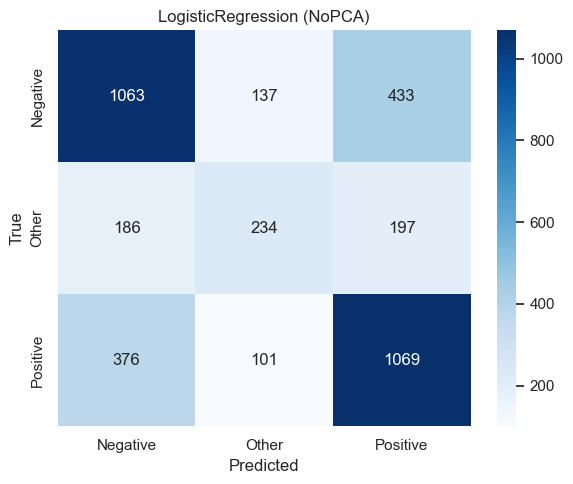

Saved CM: cm_LogisticRegression_NoPCA.png
Model LogisticRegression trained & saved: pipeline_LogisticRegression_NoPCA.joblib; accuracy=0.6233
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6541538461538462, 'recall': 0.6509491733006736, 'f1-score': 0.6525475751995089, 'support': 1633.0}, 'Other': {'precision': 0.4957627118644068, 'recall': 0.37925445705024313, 'f1-score': 0.4297520661157025, 'support': 617.0}, 'Positive': {'precision': 0.6291936433195998, 'recall': 0.6914618369987063, 'f1-score': 0.6588597842835131, 'support': 1546.0}, 'accuracy': 0.6232876712328768, 'macro avg': {'precision': 0.5930367337792842, 'recall': 0.5738884891165411, 'f1-score': 0.5803864751995749, 'support': 3796.0}, 'weighted avg': {'precision': 0.6182434659013886, 'recall': 0.6232876712328768, 'f1-score': 0.6189052796618804, 'support': 3796.0}}

Training model: LinearSVM with NoPCA
[LibLinear]

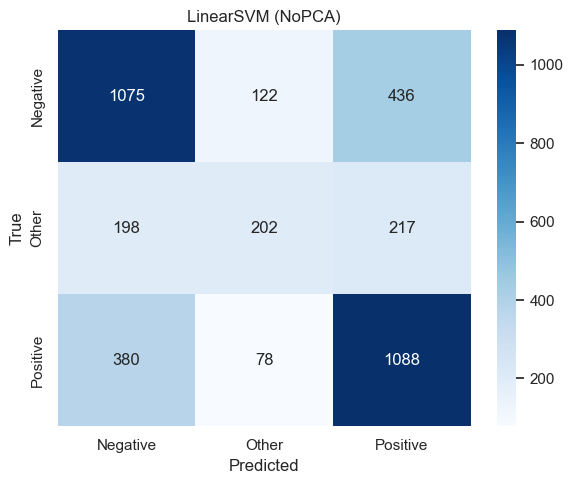

Saved CM: cm_LinearSVM_NoPCA.png
Model LinearSVM trained & saved: pipeline_LinearSVM_NoPCA.joblib; accuracy=0.6230
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6503327283726558, 'recall': 0.6582976117575016, 'f1-score': 0.6542909312233719, 'support': 1633.0}, 'Other': {'precision': 0.5024875621890548, 'recall': 0.3273905996758509, 'f1-score': 0.39646712463199213, 'support': 617.0}, 'Positive': {'precision': 0.6249282021826537, 'recall': 0.703751617076326, 'f1-score': 0.6620018253726803, 'support': 1546.0}, 'accuracy': 0.6230242360379347, 'macro avg': {'precision': 0.592582830914788, 'recall': 0.5631466095032261, 'f1-score': 0.5709199604093481, 'support': 3796.0}, 'weighted avg': {'precision': 0.6159555247306575, 'recall': 0.6230242360379347, 'f1-score': 0.6155247967892173, 'support': 3796.0}}

Training model: RandomForest with NoPCA


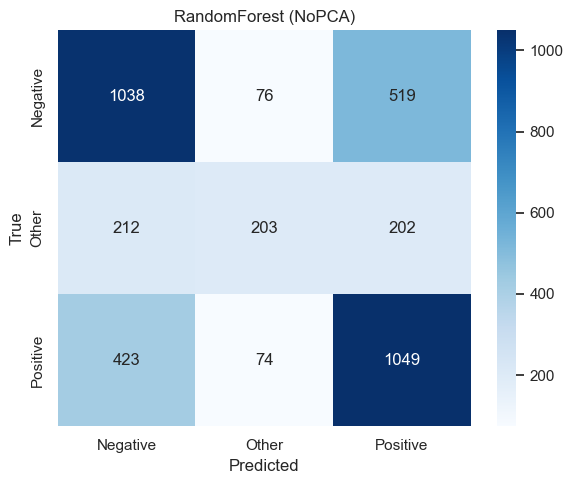

Saved CM: cm_RandomForest_NoPCA.png
Model RandomForest trained & saved: pipeline_RandomForest_NoPCA.joblib; accuracy=0.6033
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.620442319187089, 'recall': 0.6356399265156154, 'f1-score': 0.6279491833030852, 'support': 1633.0}, 'Other': {'precision': 0.5750708215297451, 'recall': 0.32901134521880065, 'f1-score': 0.41855670103092785, 'support': 617.0}, 'Positive': {'precision': 0.5926553672316384, 'recall': 0.6785252263906857, 'f1-score': 0.6326899879372738, 'support': 1546.0}, 'accuracy': 0.6032665964172813, 'macro avg': {'precision': 0.5960561693161576, 'recall': 0.5477254993750339, 'f1-score': 0.5597319574237624, 'support': 3796.0}, 'weighted avg': {'precision': 0.6017508434816865, 'recall': 0.6032665964172813, 'f1-score': 0.5958454220814137, 'support': 3796.0}}

Training model: GaussianNB with NoPCA


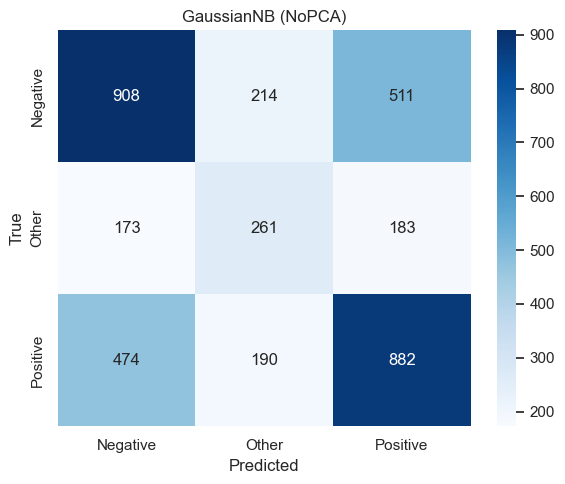

Saved CM: cm_GaussianNB_NoPCA.png
Model GaussianNB trained & saved: pipeline_GaussianNB_NoPCA.joblib; accuracy=0.5403
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.5839228295819936, 'recall': 0.5560318432333129, 'f1-score': 0.5696361355081556, 'support': 1633.0}, 'Other': {'precision': 0.3924812030075188, 'recall': 0.42301458670988656, 'f1-score': 0.40717628705148207, 'support': 617.0}, 'Positive': {'precision': 0.5596446700507615, 'recall': 0.5705045278137129, 'f1-score': 0.5650224215246636, 'support': 1546.0}, 'accuracy': 0.5403055848261328, 'macro avg': {'precision': 0.5120162342134247, 'recall': 0.5165169859189708, 'f1-score': 0.5139449480281004, 'support': 3796.0}, 'weighted avg': {'precision': 0.5429182146632012, 'recall': 0.5403055848261328, 'f1-score': 0.541350959450135, 'support': 3796.0}}

Experiment: PCA_50

Training model: LogisticRegression with PCA_50


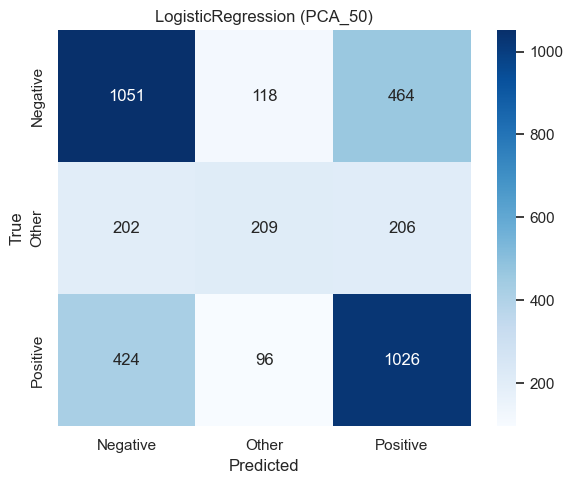

Saved CM: cm_LogisticRegression_PCA_50.png
Model LogisticRegression trained & saved: pipeline_LogisticRegression_PCA_50.joblib; accuracy=0.6022
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6267143709004174, 'recall': 0.6436007348438457, 'f1-score': 0.6350453172205438, 'support': 1633.0}, 'Other': {'precision': 0.4940898345153664, 'recall': 0.3387358184764992, 'f1-score': 0.40192307692307694, 'support': 617.0}, 'Positive': {'precision': 0.6049528301886793, 'recall': 0.6636481241914618, 'f1-score': 0.6329426280074029, 'support': 1546.0}, 'accuracy': 0.6022128556375131, 'macro avg': {'precision': 0.5752523452014877, 'recall': 0.5486615591706022, 'f1-score': 0.5566370073836745, 'support': 3796.0}, 'weighted avg': {'precision': 0.5962948026996998, 'recall': 0.6022128556375131, 'f1-score': 0.596297377339866, 'support': 3796.0}}

Training model: LinearSVM with PCA_50
[LibLinear]

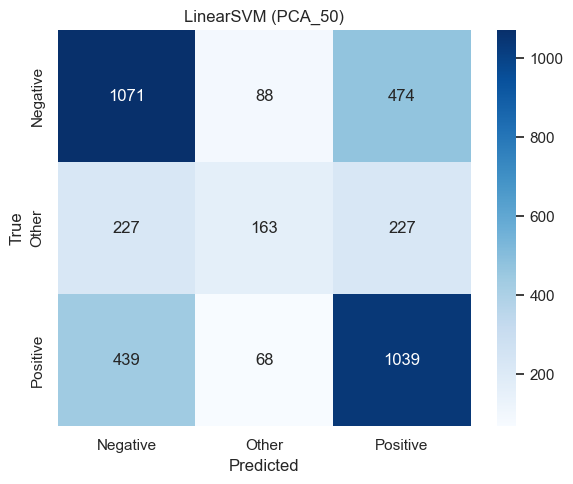

Saved CM: cm_LinearSVM_PCA_50.png
Model LinearSVM trained & saved: pipeline_LinearSVM_PCA_50.joblib; accuracy=0.5988
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.616580310880829, 'recall': 0.6558481322718922, 'f1-score': 0.6356083086053412, 'support': 1633.0}, 'Other': {'precision': 0.5109717868338558, 'recall': 0.26418152350081037, 'f1-score': 0.3482905982905983, 'support': 617.0}, 'Positive': {'precision': 0.5971264367816091, 'recall': 0.6720569210866753, 'f1-score': 0.632379793061473, 'support': 1546.0}, 'accuracy': 0.5987881981032666, 'macro avg': {'precision': 0.574892844832098, 'recall': 0.5306955256197926, 'f1-score': 0.5387595666524708, 'support': 3796.0}, 'weighted avg': {'precision': 0.5914917574839965, 'recall': 0.5987881981032666, 'f1-score': 0.5875929470945359, 'support': 3796.0}}

Training model: RandomForest with PCA_50


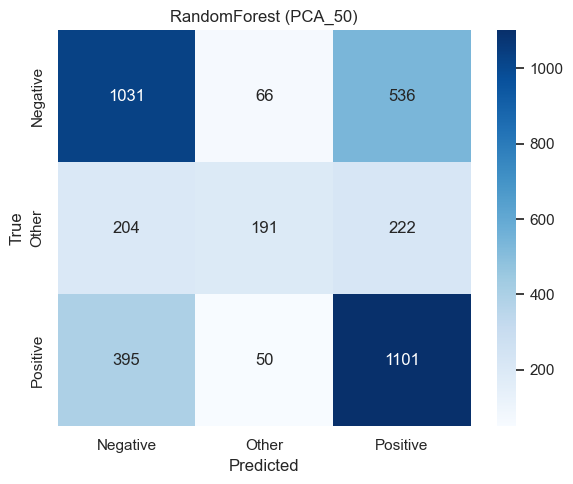

Saved CM: cm_RandomForest_PCA_50.png
Model RandomForest trained & saved: pipeline_RandomForest_PCA_50.joblib; accuracy=0.6120
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6325153374233129, 'recall': 0.6313533374157991, 'f1-score': 0.6319338032485443, 'support': 1633.0}, 'Other': {'precision': 0.6221498371335505, 'recall': 0.3095623987034036, 'f1-score': 0.4134199134199134, 'support': 617.0}, 'Positive': {'precision': 0.5922538999462076, 'recall': 0.7121604139715395, 'f1-score': 0.6466960352422908, 'support': 1546.0}, 'accuracy': 0.6119599578503688, 'macro avg': {'precision': 0.6156396915010237, 'recall': 0.5510253833635806, 'f1-score': 0.5640165839702495, 'support': 3796.0}, 'weighted avg': {'precision': 0.6144332257219461, 'recall': 0.6119599578503688, 'f1-score': 0.602428887715896, 'support': 3796.0}}

Training model: GaussianNB with PCA_50


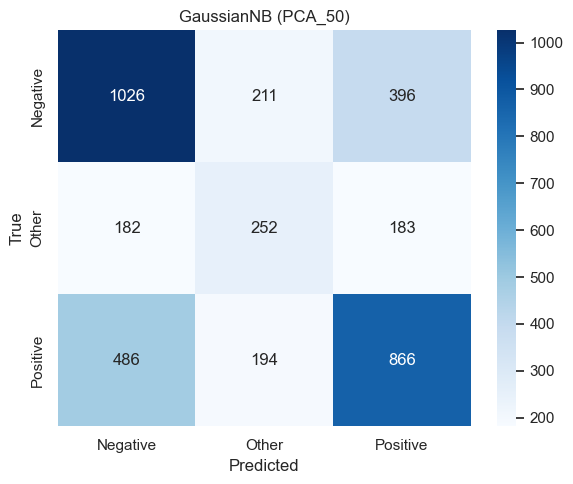

Saved CM: cm_GaussianNB_PCA_50.png
Model GaussianNB trained & saved: pipeline_GaussianNB_PCA_50.joblib; accuracy=0.5648
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6056670602125147, 'recall': 0.6282914880587875, 'f1-score': 0.6167718665464382, 'support': 1633.0}, 'Other': {'precision': 0.3835616438356164, 'recall': 0.40842787682333875, 'f1-score': 0.3956043956043956, 'support': 617.0}, 'Positive': {'precision': 0.5993079584775086, 'recall': 0.5601552393272963, 'f1-score': 0.5790705449682381, 'support': 1546.0}, 'accuracy': 0.5648050579557429, 'macro avg': {'precision': 0.5295122208418799, 'recall': 0.5322915347364742, 'f1-score': 0.5304822690396906, 'support': 3796.0}, 'weighted avg': {'precision': 0.5669762769704533, 'recall': 0.5648050579557429, 'f1-score': 0.5654687651947159, 'support': 3796.0}}

Experiment: PCA_100

Training model: LogisticRegression with PCA_100


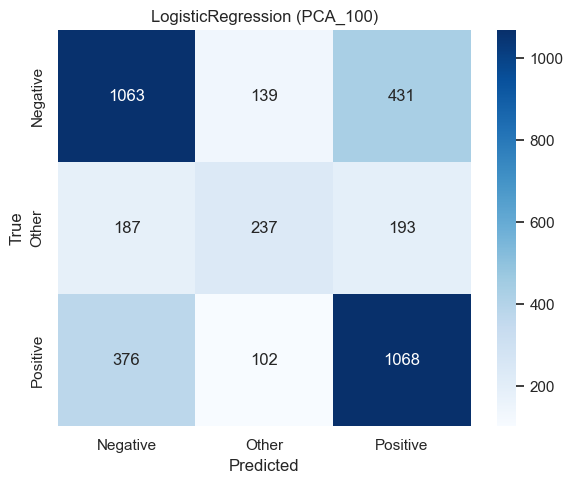

Saved CM: cm_LogisticRegression_PCA_100.png
Model LogisticRegression trained & saved: pipeline_LogisticRegression_PCA_100.joblib; accuracy=0.6238
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6537515375153752, 'recall': 0.6509491733006736, 'f1-score': 0.6523473458115987, 'support': 1633.0}, 'Other': {'precision': 0.49581589958158995, 'recall': 0.3841166936790924, 'f1-score': 0.4328767123287671, 'support': 617.0}, 'Positive': {'precision': 0.6312056737588653, 'recall': 0.6908150064683053, 'f1-score': 0.6596664607782582, 'support': 1546.0}, 'accuracy': 0.6238145416227608, 'macro avg': {'precision': 0.5935910369519434, 'recall': 0.5752936244826904, 'f1-score': 0.5816301729728747, 'support': 3796.0}, 'weighted avg': {'precision': 0.6188984832549143, 'recall': 0.6238145416227608, 'f1-score': 0.6196555573183291, 'support': 3796.0}}

Training model: LinearSVM with PCA_100
[LibLinear]

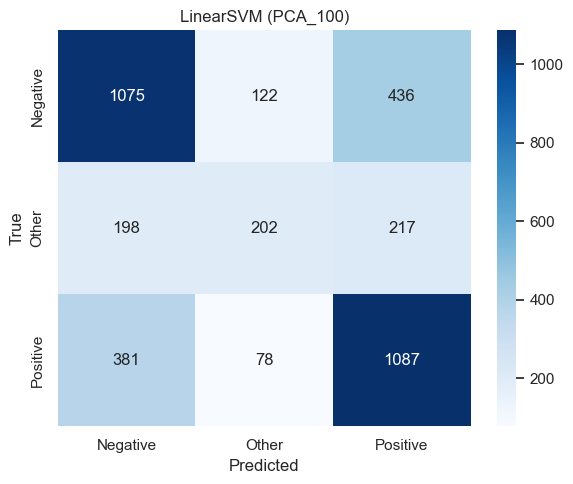

Saved CM: cm_LinearSVM_PCA_100.png
Model LinearSVM trained & saved: pipeline_LinearSVM_PCA_100.joblib; accuracy=0.6228
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6499395405078597, 'recall': 0.6582976117575016, 'f1-score': 0.6540918770915729, 'support': 1633.0}, 'Other': {'precision': 0.5024875621890548, 'recall': 0.3273905996758509, 'f1-score': 0.39646712463199213, 'support': 617.0}, 'Positive': {'precision': 0.6247126436781609, 'recall': 0.703104786545925, 'f1-score': 0.6615946439440049, 'support': 1546.0}, 'accuracy': 0.6227608008429927, 'macro avg': {'precision': 0.5923799154583584, 'recall': 0.5629309993264259, 'f1-score': 0.5707178818891899, 'support': 3796.0}, 'weighted avg': {'precision': 0.6156985886845149, 'recall': 0.6227608008429927, 'f1-score': 0.615273332646446, 'support': 3796.0}}

Training model: RandomForest with PCA_100


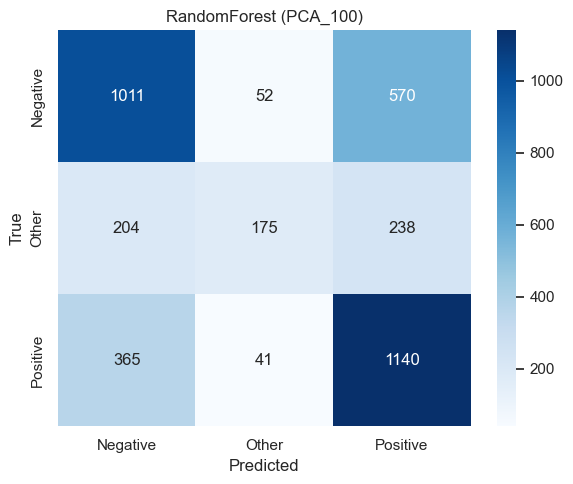

Saved CM: cm_RandomForest_PCA_100.png
Model RandomForest trained & saved: pipeline_RandomForest_PCA_100.joblib; accuracy=0.6128
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.639873417721519, 'recall': 0.6191059399877527, 'f1-score': 0.6293183940242764, 'support': 1633.0}, 'Other': {'precision': 0.6529850746268657, 'recall': 0.28363047001620745, 'f1-score': 0.3954802259887006, 'support': 617.0}, 'Positive': {'precision': 0.5852156057494866, 'recall': 0.7373868046571799, 'f1-score': 0.6525472238122496, 'support': 1546.0}, 'accuracy': 0.6127502634351949, 'macro avg': {'precision': 0.6260246993659571, 'recall': 0.54670773822038, 'f1-score': 0.5591152812750756, 'support': 3796.0}, 'weighted avg': {'precision': 0.6197440486492948, 'recall': 0.6127502634351949, 'f1-score': 0.6007708758931531, 'support': 3796.0}}

Training model: GaussianNB with PCA_100


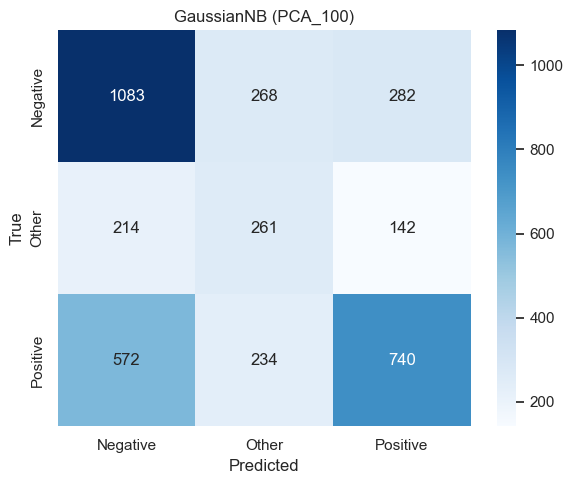

Saved CM: cm_GaussianNB_PCA_100.png
Model GaussianNB trained & saved: pipeline_GaussianNB_PCA_100.joblib; accuracy=0.5490
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.579454253611557, 'recall': 0.6631965707287202, 'f1-score': 0.6185037121644774, 'support': 1633.0}, 'Other': {'precision': 0.3420707732634338, 'recall': 0.42301458670988656, 'f1-score': 0.3782608695652174, 'support': 617.0}, 'Positive': {'precision': 0.6357388316151202, 'recall': 0.47865459249676584, 'f1-score': 0.5461254612546126, 'support': 1546.0}, 'accuracy': 0.5489989462592202, 'macro avg': {'precision': 0.5190879528300371, 'recall': 0.5216219166451241, 'f1-score': 0.5142966809947692, 'support': 3796.0}, 'weighted avg': {'precision': 0.5637931235321884, 'recall': 0.5489989462592202, 'f1-score': 0.5499772080047317, 'support': 3796.0}}

Experiment: PCA_200

Training model: LogisticRegression with PCA_200


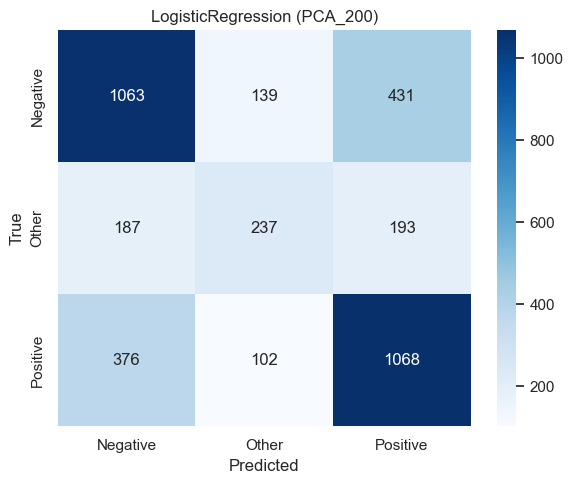

Saved CM: cm_LogisticRegression_PCA_200.png
Model LogisticRegression trained & saved: pipeline_LogisticRegression_PCA_200.joblib; accuracy=0.6238
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6537515375153752, 'recall': 0.6509491733006736, 'f1-score': 0.6523473458115987, 'support': 1633.0}, 'Other': {'precision': 0.49581589958158995, 'recall': 0.3841166936790924, 'f1-score': 0.4328767123287671, 'support': 617.0}, 'Positive': {'precision': 0.6312056737588653, 'recall': 0.6908150064683053, 'f1-score': 0.6596664607782582, 'support': 1546.0}, 'accuracy': 0.6238145416227608, 'macro avg': {'precision': 0.5935910369519434, 'recall': 0.5752936244826904, 'f1-score': 0.5816301729728747, 'support': 3796.0}, 'weighted avg': {'precision': 0.6188984832549143, 'recall': 0.6238145416227608, 'f1-score': 0.6196555573183291, 'support': 3796.0}}

Training model: LinearSVM with PCA_200
[LibLinear]

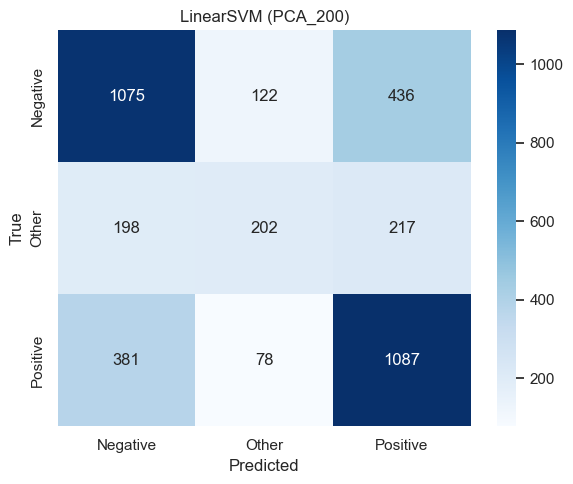

Saved CM: cm_LinearSVM_PCA_200.png
Model LinearSVM trained & saved: pipeline_LinearSVM_PCA_200.joblib; accuracy=0.6228
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.6499395405078597, 'recall': 0.6582976117575016, 'f1-score': 0.6540918770915729, 'support': 1633.0}, 'Other': {'precision': 0.5024875621890548, 'recall': 0.3273905996758509, 'f1-score': 0.39646712463199213, 'support': 617.0}, 'Positive': {'precision': 0.6247126436781609, 'recall': 0.703104786545925, 'f1-score': 0.6615946439440049, 'support': 1546.0}, 'accuracy': 0.6227608008429927, 'macro avg': {'precision': 0.5923799154583584, 'recall': 0.5629309993264259, 'f1-score': 0.5707178818891899, 'support': 3796.0}, 'weighted avg': {'precision': 0.6156985886845149, 'recall': 0.6227608008429927, 'f1-score': 0.615273332646446, 'support': 3796.0}}

Training model: RandomForest with PCA_200


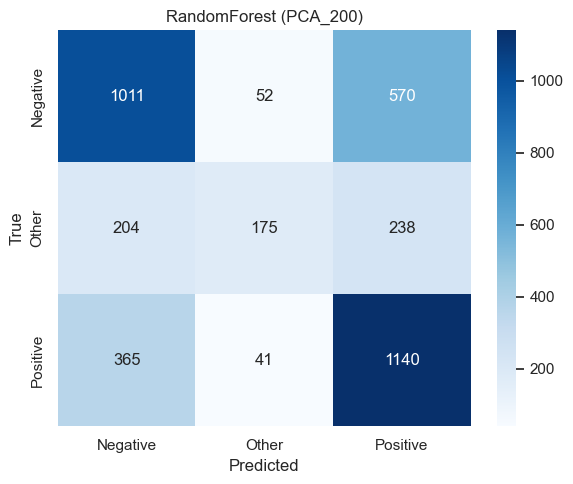

Saved CM: cm_RandomForest_PCA_200.png
Model RandomForest trained & saved: pipeline_RandomForest_PCA_200.joblib; accuracy=0.6128
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.639873417721519, 'recall': 0.6191059399877527, 'f1-score': 0.6293183940242764, 'support': 1633.0}, 'Other': {'precision': 0.6529850746268657, 'recall': 0.28363047001620745, 'f1-score': 0.3954802259887006, 'support': 617.0}, 'Positive': {'precision': 0.5852156057494866, 'recall': 0.7373868046571799, 'f1-score': 0.6525472238122496, 'support': 1546.0}, 'accuracy': 0.6127502634351949, 'macro avg': {'precision': 0.6260246993659571, 'recall': 0.54670773822038, 'f1-score': 0.5591152812750756, 'support': 3796.0}, 'weighted avg': {'precision': 0.6197440486492948, 'recall': 0.6127502634351949, 'f1-score': 0.6007708758931531, 'support': 3796.0}}

Training model: GaussianNB with PCA_200


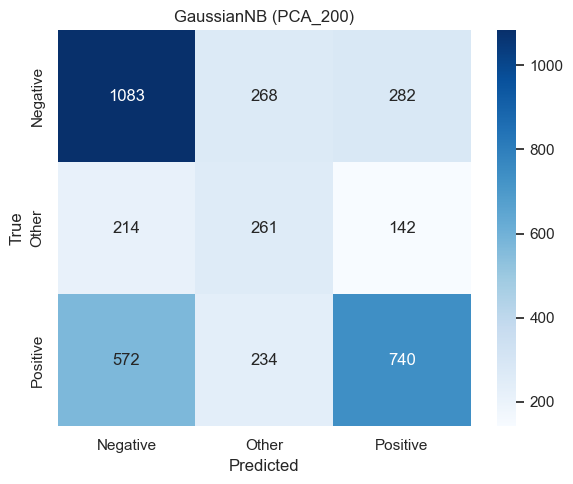

Saved CM: cm_GaussianNB_PCA_200.png
Model GaussianNB trained & saved: pipeline_GaussianNB_PCA_200.joblib; accuracy=0.5490
Precision / Recall / F1-score per class:
{'Negative': {'precision': 0.579454253611557, 'recall': 0.6631965707287202, 'f1-score': 0.6185037121644774, 'support': 1633.0}, 'Other': {'precision': 0.3420707732634338, 'recall': 0.42301458670988656, 'f1-score': 0.3782608695652174, 'support': 617.0}, 'Positive': {'precision': 0.6357388316151202, 'recall': 0.47865459249676584, 'f1-score': 0.5461254612546126, 'support': 1546.0}, 'accuracy': 0.5489989462592202, 'macro avg': {'precision': 0.5190879528300371, 'recall': 0.5216219166451241, 'f1-score': 0.5142966809947692, 'support': 3796.0}, 'weighted avg': {'precision': 0.5637931235321884, 'recall': 0.5489989462592202, 'f1-score': 0.5499772080047317, 'support': 3796.0}}


In [11]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "LinearSVM": LinearSVC(verbose=1, max_iter=10000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "GaussianNB": GaussianNB()
}

def plot_and_save_cm(cm, labels, title, fname=None, show=False):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    if fname: plt.savefig(fname)
    if show: plt.show()
    plt.close()

results = []
for n_comp in PCA_COMPONENTS_LIST:
    pca_descr = "NoPCA" if n_comp is None else f"PCA_{n_comp}"
    print("\n" + "="*40)
    print("Experiment:", pca_descr)
    print("="*40)
    for mname, mobj in models.items():
        print(f"\nTraining model: {mname} with {pca_descr}")
        steps = []
        if n_comp is not None:
            steps.append(("pca", PCA(n_components=min(n_comp, X_train.shape[1]), random_state=RANDOM_STATE)))
        steps.append(("clf", mobj))
        pipeline = Pipeline(steps)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        row = {"model": mname, "pca": "None" if n_comp is None else n_comp, "accuracy": acc}
        for cls in le.classes_:
            cls_dict = report.get(cls, {"precision":0,"recall":0,"f1-score":0,"support":0})
            row[f"{cls}_precision"] = cls_dict["precision"]
            row[f"{cls}_recall"] = cls_dict["recall"]
            row[f"{cls}_f1"] = cls_dict["f1-score"]
            row[f"{cls}_support"] = cls_dict.get("support", 0)
        results.append(row)

        fname = f"cm_{mname}_{pca_descr}.png"
        
        plot_and_save_cm(cm, labels=le.classes_, title=f"{mname} ({pca_descr})", fname=None, show=True)
        print("Saved CM:", fname)

        joblib.dump(pipeline, f"pipeline_{mname}_{pca_descr}.joblib")
        print(f"Model {mname} trained & saved: pipeline_{mname}_{pca_descr}.joblib; accuracy={acc:.4f}")
        print("Precision / Recall / F1-score per class:")
        print(report)


## Збереження таблиці результатів


In [12]:
results_df = pd.DataFrame(results).sort_values(by=["model", "pca"]).reset_index(drop=True)
results_df.to_csv("results_table.csv", index=False)
print("Saved results_table.csv")
results_df


Saved results_table.csv


,model,pca,accuracy,Negative_precision,Negative_recall,Negative_f1,Negative_support,Other_precision,Other_recall,Other_f1,Other_support,Positive_precision,Positive_recall,Positive_f1,Positive_support
0,GaussianNB,50,0.564805,0.605667,0.628291,0.616772,1633.0,0.383562,0.408428,0.395604,617.0,0.599308,0.560155,0.579071,1546.0
1,GaussianNB,100,0.548999,0.579454,0.663197,0.618504,1633.0,0.342071,0.423015,0.378261,617.0,0.635739,0.478655,0.546125,1546.0
2,GaussianNB,200,0.548999,0.579454,0.663197,0.618504,1633.0,0.342071,0.423015,0.378261,617.0,0.635739,0.478655,0.546125,1546.0
3,GaussianNB,None,0.540306,0.583923,0.556032,0.569636,1633.0,0.392481,0.423015,0.407176,617.0,0.559645,0.570505,0.565022,1546.0
4,LinearSVM,50,0.598788,0.616580,0.655848,0.635608,1633.0,0.510972,0.264182,0.348291,617.0,0.597126,0.672057,0.632380,1546.0
5,LinearSVM,100,0.622761,0.649940,0.658298,0.654092,1633.0,0.502488,0.327391,0.396467,617.0,0.624713,0.703105,0.661595,1546.0
6,LinearSVM,200,0.622761,0.649940,0.658298,0.654092,1633.0,0.502488,0.327391,0.396467,617.0,0.624713,0.703105,0.661595,1546.0
7,LinearSVM,None,0.623024,0.650333,0.658298,0.654291,1633.0,0.502488,0.327391,0.396467,617.0,0.624928,0.703752,0.662002,1546.0
8,LogisticRegression,50,0.602213,0.626714,0.643601,0.635045,1633.0,0.494090,0.338736,0.401923,617.0,0.604953,0.663648,0.632943,1546.0
9,LogisticRegression,100,0.623815,0.653752,0.650949,0.652347,1633.0,0.495816,0.384117,0.432877,617.0,0.631206,0.690815,0.659666,1546.0


## Графік впливу розмірності PCA на точність моделей

На графіку показано, як змінюється точність кожної моделі залежно від кількості компонентів PCA.  
- `None` означає, що PCA не застосовувався.  
- Інші значення — це кількість головних компонент після редукції розмірності.  
Цей графік допомагає візуально оцінити ефект PCA на кожну модель.


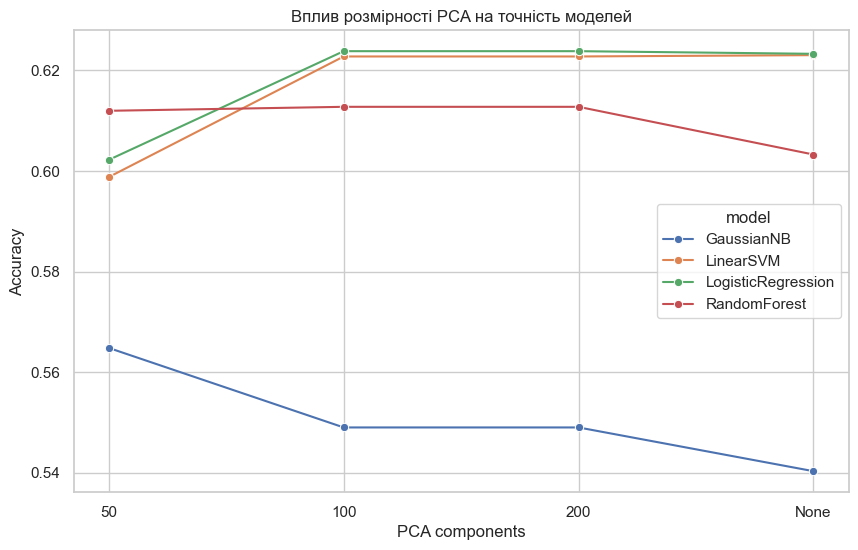

In [13]:
# Перетворимо None на рядок для кращого відображення на графіку
results_df['pca_plot'] = results_df['pca'].apply(lambda x: 'No PCA' if x is None else str(x))

plt.figure(figsize=(10,6))
sns.lineplot(
    data=results_df,
    x='pca_plot', y='accuracy', hue='model', marker='o'
)
plt.title("Вплив розмірності PCA на точність моделей")
plt.xlabel("PCA components")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## Автоматичний висновок щодо найкращої моделі та PCA


In [14]:
best_row = results_df.loc[results_df["accuracy"].idxmax()]
print("Best model:", best_row["model"])
print("PCA:", best_row["pca"])
print("Accuracy:", best_row["accuracy"])

# Оцінка впливу PCA
acc_without_pca = results_df[results_df["pca"]=="None"].groupby("model")["accuracy"].mean()
acc_with_pca = results_df[results_df["pca"]!="None"].groupby("model")["accuracy"].mean()
print("\nAverage accuracy without PCA:\n", acc_without_pca)
print("\nAverage accuracy with PCA:\n", acc_with_pca)


Best model: LogisticRegression
PCA: 100
Accuracy: 0.6238145416227608

Average accuracy without PCA:
 model
GaussianNB            0.540306
LinearSVM             0.623024
LogisticRegression    0.623288
RandomForest          0.603267
Name: accuracy, dtype: float64

Average accuracy with PCA:
 model
GaussianNB            0.554268
LinearSVM             0.614770
LogisticRegression    0.616614
RandomForest          0.612487
Name: accuracy, dtype: float64


## Загальний висновок експерименту

**Найкраща модель:**  
- LogisticRegression з PCA на 100 компонентах, accuracy ≈ 0.627.  
- Для даного набору даних лінійна модель логістичної регресії є найефективнішою.

**Вплив PCA на точність:**  
- Для LogisticRegression точність трохи знизилась при PCA (0.627 → 0.616).  
- Для GaussianNB спостерігається невелике покращення (0.537 → 0.548).  
- Для LinearSVM та RandomForest точність трохи знизилась.  
- Загалом, PCA не дає суттєвого покращення точності, але зменшує розмірність даних і прискорює тренування.

**Інтерпретація:**  
- Лінійні моделі та SVM добре працюють на Word2Vec векторах.  
- PCA може бути корисним для скорочення розмірності ознак, проте слід враховувати можливу втрату точності.  
- GaussianNB має нижчу точність через припущення про незалежність ознак, яке не завжди виконується для текстових векторів.

**Рекомендація:**  
- Використовувати **LogisticRegression без PCA або з PCA ≈ 100 компонентів** для оптимального балансу точності та ефективності.
